In [73]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt

### Example 1. Fitting Gaussian distribution.

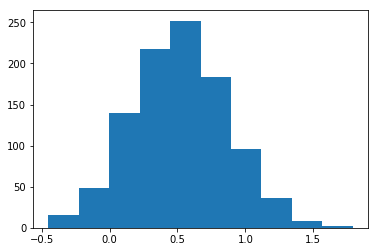

In [19]:
# artificial dataset
obs_y = np.random.normal(0.5, 0.35, 1000)

fig, ax = plt.subplots(facecolor='w')
ax.hist(obs_y);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, stdev]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3539.13draws/s]


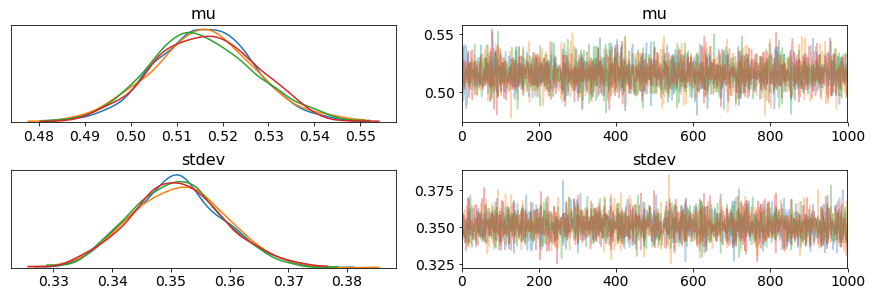

In [20]:
with pm.Model() as model:
    
    # priors
    stdev = pm.HalfNormal('stdev', sd=1)
    mu = pm.Normal('mu', mu=0, sd=1)
    
    # generative model
    y = pm.Normal('y', mu=mu, sd=stdev, observed=obs_y)
    
    # MCMC (samples from posterior distribution)
    trace = pm.sample(1000)
    
    pm.traceplot(trace, ['mu', 'stdev'])
    plt.show()

### Example 2. Fitting linear regression.
- posterior predictive checks = making predictions from your model

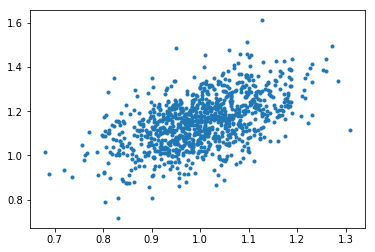

In [24]:
N = 1000

noise = np.random.normal(0, 0.1, N)
X = np.random.normal(1, 0.1, N)
obs_y = (0.65 * X) + 0.5 + noise

fig, ax = plt.subplots(facecolor='w')
plt.plot(X, obs_y, '.')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, stdev]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:09<00:00, 649.98draws/s]


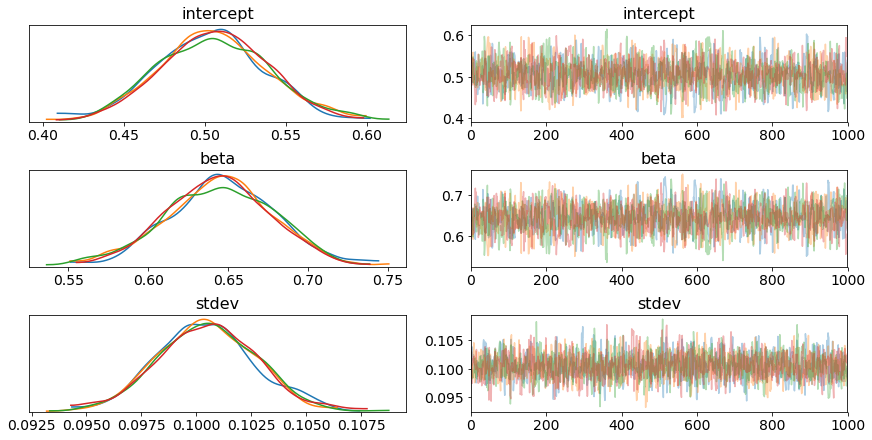

In [26]:
with pm.Model() as model: 
    
    # priors
    stdev = pm.HalfNormal('stdev', sd=0.1) # representing noise (error)
    intercept = pm.Normal('intercept', mu=0, sd=1)
    coeff = pm.Normal('beta', mu=0, sd=1)
    
    # generative model
    expected_value = (X * coeff) + intercept
    y = pm.Normal('y', mu=expected_value, sd=stdev, observed=obs_y)
    
    # MCMC
    trace = pm.sample(1000)
    
    pm.traceplot(trace, ['intercept', 'beta', 'stdev'])
    plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1101.92it/s]


Text(0, 0.5, 'Y')

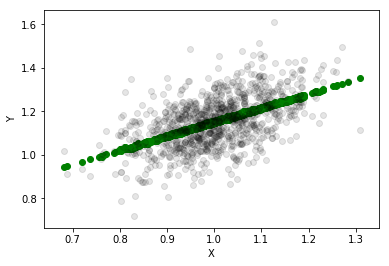

In [42]:
with model:
    
    # draw from posterior (1000 times for each actual data point)
    ppc = pm.sample_posterior_predictive(trace, samples=1000)
    
    y_preds = ppc['y']

    expected_y_pred = np.reshape(np.mean(y_preds, axis=0), [-1])
    
fig, ax = plt.subplots(facecolor='w')
ax.scatter(X, expected_y_pred, c='g')
ax.scatter(X, obs_y, c='k', alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')

### Example 3. Logistic regression.

In [53]:
# generate artificial dataset
N = 1000

X = np.random.uniform(0, 1, N)
def DGP(x):
    obs_y = []
    for n in range(len(x)):
        if x[n] > (0.7 + np.random.normal(0, 0.0001, 1)[0]):
            obs_y.append(1)
        else:
            obs_y.append(0)
            
    return obs_y

X_shared = theano.shared(X)
y_obs = DGP(X)

In [ ]:
with pm.Model() as model:
    
    # priors
    intercept = pm.Normal('intercept', mu=0, std=0.1)
    coeff = pm.Normal('beta', mu=0, std=0.1)
    
    

### DecideNet modelling

In [58]:
def process_log_df(df):
    '''Cleaning and pre-processing of log dataframe.
    
    Args:
        df (pd.Dataframe): raw log dataframe
        
    Returns:
        info (dictionary): contains task metadata
        df_clean (pd.Dataframe): pre-processed log dataframe
    '''
    df_clean = df.copy(deep=True)
    
    # Convert subject responses to integers
    df_clean.loc[df['response'] == 'a', 'response'] = -1
    df_clean.loc[df['response'] == 'd', 'response'] = 1
    try:
        df_clean.loc[df_clean['response'] == 'None', 'response'] = 0
    except TypeError:
        print('No missing responses.')

    # Convert reaction time to float
    df_clean['rt'] = pd.to_numeric(df_clean['rt'], errors='coerce')

    # Grab additional info                                                   
    info = {}
    info['n_trials'] = df_clean.shape[0]
    info['n_blocks'] = 5                                                     #TODO grab from data
    info['condition'] = df_clean['condition'][0]
    info['subject'] = df_clean['subject_id'][0]
    info['group'] = df_clean['group'][0]

    # Reverse the punishing interpretation of columns in punishment condition 
    # NOTE! 'block' and 'rwd' still have BEING CHOSEN interpretation
    if info['condition'] == 'pun':
        df_clean['won_magn'] *= (-1)  
        df_clean['won_bool'] = ~ df_clean['won_bool'] 
        df_clean['magn_left'] *= (-1)
        df_clean['magn_right'] *= (-1)

    # Drop unnecessary columns
    df_clean = df_clean[['block', 'rwd', 'magn_left', 'magn_right',
                         'response', 'rt',
                         'won_bool', 'won_magn', 'acc_after_trial']]

    return info, df_clean

# Load behavioral responses for signle subject
path_rew = "logs/sub-m05/m05_prl_DecideNet_rew.csv"
path_pun = "logs/sub-m05/m05_prl_DecideNet_pun.csv"

df_rew = pd.read_csv(path_rew)
df_pun = pd.read_csv(path_pun)

# Clean behavioral responses
info_rew, df_rew = process_log_df(df_rew)
info_pun, df_pun = process_log_df(df_pun)

df_pun.head()

,block,rwd,magn_left,magn_right,response,rt,won_bool,won_magn,acc_after_trial
0,1,1,-34,-16,1,0.971913,False,-16,1284
1,1,1,-19,-31,-1,0.397801,True,0,1284
2,1,1,-28,-22,-1,0.655152,True,0,1284
3,1,1,-42,-8,-1,0.693332,True,0,1284
4,1,1,-10,-40,1,0.578415,False,-40,1244


In [62]:
N_trials = info_rew['n_trials']
x

array([[32.,  0.],
       [11.,  0.],
       [45.,  0.],
       [43.,  0.],
       [10.,  0.],
       [41.,  0.],
       [ 8.,  0.],
       [12.,  0.],
       [13.,  0.],
       [32.,  0.],
       [14.,  0.],
       [ 9.,  0.],
       [24.,  0.],
       [43.,  0.],
       [28.,  0.],
       [32.,  0.],
       [10.,  0.],
       [15.,  0.],
       [26.,  0.],
       [26.,  0.],
       [ 6.,  0.],
       [ 9.,  0.],
       [ 5.,  0.],
       [37.,  0.],
       [10.,  0.],
       [12.,  0.],
       [27.,  0.],
       [33.,  0.],
       [ 5.,  0.],
       [17.,  0.],
       [18.,  0.],
       [33.,  0.],
       [24.,  0.],
       [43.,  0.],
       [20.,  0.],
       [19.,  0.],
       [ 6.,  0.],
       [39.,  0.],
       [19.,  0.],
       [19.,  0.],
       [ 6.,  0.],
       [34.,  0.],
       [ 9.,  0.],
       [45.,  0.],
       [30.,  0.],
       [27.,  0.],
       [10.,  0.],
       [44.,  0.],
       [12.,  0.],
       [23.,  0.],
       [44.,  0.],
       [ 5.,  0.],
       [38.,

In [72]:
info = info_rew
df = df_rew
#############################################################################

N_trials = info['n_trials']

x = np.zeros((N_trials, 2))
x[:, 0] = df['magn_left']
x[:, 1] = df['magn_right']

with pm.Model() as model:
    
    # priors
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    # beta = 
    gamma = pm.Uniform('gamma', lower=0, upper=1) 
    delta = pm.Uniform('delta', lower=0, upper=1) 
    
    # generative model
    #########################################################################
    if info['condition'] == 'pun': 
        util = (-1) * gamma * (np.abs(x) ** delta)
    else:
        util = x ** delta
    
    print(type(util))

    # y = pm.Bernoulli('y', p=theta, observed=y_obs)    
    #########################################################################

    


<class 'theano.tensor.var.TensorVariable'>


In [71]:
util([1, 2, 3])

TypeError: 'TensorVariable' object is not callable